In [1]:
mname = 'preresnet_x67'
seed = 723
fold = 0

In [2]:
gpu_id = 0
nfold = 4

In [3]:
# initialize weights from this model
mname0 = 'preresnet_u67'

In [4]:
import socket
import timeit
import time
from datetime import datetime
import os
from os import listdir
from os.path import isfile, join
import glob
from collections import OrderedDict
import numpy as np
import pandas as pd
import pickle
import gc
import cv2
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
import seaborn as sns
sns.set_style("white")
import random
import PIL
import pathlib
import math

import torch
from torch.autograd import Variable
import torch.optim as optim
from torch.utils import data
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.utils import make_grid
from torch import nn
from torch.nn import functional as F
from torch.optim.lr_scheduler import LambdaLR, ReduceLROnPlateau, StepLR
from torch.utils.data.sampler import WeightedRandomSampler
import torchvision

import albumentations as A

from skimage.exposure import histogram, equalize_hist, equalize_adapthist
from skimage.morphology import binary_dilation

import pretrainedmodels
from xception import xception

from tensorboardX import SummaryWriter

from scipy.special import logit
from scipy.ndimage.filters import gaussian_filter

from sklearn.metrics import jaccard_similarity_score, f1_score
from sklearn.preprocessing import MultiLabelBinarizer

import imgaug as ia
from imgaug import augmenters as iaa
import multiprocessing
import threading

from dataloaders import utils
from dataloaders import custom_transforms as tr

# from losses import CombinedLoss, BCELoss2d
from losses import FocalLoss, ThreeWayLoss, L1_LossW, Smooth_L1_LossW
import lovasz_losses as L

In [5]:
ori_size = 1024
up_size = 1024
image_size = 1024
final_size = 1024

interp = cv2.INTER_AREA
# methods=[("area", cv2.INTER_AREA), 
#          ("nearest", cv2.INTER_NEAREST), 
#          ("linear", cv2.INTER_LINEAR), 
#          ("cubic", cv2.INTER_CUBIC), 
#          ("lanczos4", cv2.INTER_LANCZOS4)]

y_pad = image_size - up_size
y_min_pad = int(y_pad / 2)
y_max_pad = y_pad - y_min_pad

x_pad = image_size - up_size
x_min_pad = int(x_pad / 2)
x_max_pad = x_pad - x_min_pad

print(ori_size, up_size, image_size, final_size)

1024 1024 1024 1024


In [6]:
PATH = './'

PATH_TO_TRAIN = PATH + 'train_1024/'
PATH_TO_TEST = PATH + 'test_1024/'
PATH_TO_EXTERNAL = PATH + 'external_data/'
PATH_TO_EXTERNAL2 = './external_data2/'
PATH_TO_EXTERNAL3 = './external_data3/'
PATH_TO_TARGET = PATH + 'train.csv'
PATH_TO_TARGETX = PATH + 'subcellular_location.tsv'
PATH_TO_TARGETXX = './HPAv18Y.csv'
PATH_TO_SUB = PATH + 'sample_submission.csv'

clusters = pd.read_csv('cluster4x_folds.csv')
folds = dict(zip(clusters.Id,clusters.cluster4))

LABEL_MAP = {
0: "Nucleoplasm" ,
1: "Nuclear membrane"   ,
2: "Nucleoli"   ,
3: "Nucleoli fibrillar center",   
4: "Nuclear speckles"   ,
5: "Nuclear bodies"   ,
6: "Endoplasmic reticulum"   ,
7: "Golgi apparatus"  ,
8: "Peroxisomes"   ,
9:  "Endosomes"   ,
10: "Lysosomes"   ,
11: "Intermediate filaments"  , 
12: "Actin filaments"   ,
13: "Focal adhesion sites"  ,
14: "Microtubules"   ,
15: "Microtubule ends"   ,
16: "Cytokinetic bridge"   ,
17: "Mitotic spindle"  ,
18: "Microtubule organizing center",  
19: "Centrosome",
20: "Lipid droplets"   ,
21: "Plasma membrane"  ,
22: "Cell junctions"   ,
23: "Mitochondria"   ,
24: "Aggresome"   ,
25: "Cytosol" ,
26: "Cytoplasmic bodies",
27: "Rods & rings"}

LOC_MAP = {}
for k in LABEL_MAP.keys(): LOC_MAP[LABEL_MAP[k]] = k

In [7]:
print(pretrainedmodels.model_names)

['fbresnet152', 'bninception', 'resnext101_32x4d', 'resnext101_64x4d', 'inceptionv4', 'inceptionresnetv2', 'alexnet', 'densenet121', 'densenet169', 'densenet201', 'densenet161', 'resnet18', 'resnet34', 'resnet50', 'resnet101', 'resnet152', 'inceptionv3', 'squeezenet1_0', 'squeezenet1_1', 'vgg11', 'vgg11_bn', 'vgg13', 'vgg13_bn', 'vgg16', 'vgg16_bn', 'vgg19_bn', 'vgg19', 'nasnetamobile', 'nasnetalarge', 'dpn68', 'dpn68b', 'dpn92', 'dpn98', 'dpn131', 'dpn107', 'xception', 'senet154', 'se_resnet50', 'se_resnet101', 'se_resnet152', 'se_resnext50_32x4d', 'se_resnext101_32x4d', 'cafferesnet101', 'pnasnet5large', 'polynet']


In [8]:
print(pretrainedmodels.pretrained_settings['resnet34'])

{'imagenet': {'url': 'https://download.pytorch.org/models/resnet34-333f7ec4.pth', 'input_space': 'RGB', 'input_size': [3, 224, 224], 'input_range': [0, 1], 'mean': [0.485, 0.456, 0.406], 'std': [0.229, 0.224, 0.225], 'num_classes': 1000}}


In [9]:
df = pd.read_csv(PATH_TO_TARGET)
df.set_index('Id',inplace=True)
print(df.head())
print(df.shape)

                                       Target
Id                                           
00070df0-bbc3-11e8-b2bc-ac1f6b6435d0     16 0
000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0  7 1 2 0
000a9596-bbc4-11e8-b2bc-ac1f6b6435d0        5
000c99ba-bba4-11e8-b2b9-ac1f6b6435d0        1
001838f8-bbca-11e8-b2bc-ac1f6b6435d0       18
(31072, 1)


In [10]:
# # external data
# # https://www.proteinatlas.org/download/subcellular_location.tsv.zip
# dg = pd.read_csv(PATH_TO_TARGETX, sep="\t",index_col = None)
# dg.set_index('Gene',inplace=True)
# print(dg.head())
# print(dg.shape)

# file_list_x = [f for f in listdir(PATH_TO_EXTERNAL) if isfile(join(PATH_TO_EXTERNAL,
#                                                                    f))]
# print(file_list_x[:15],len(file_list_x))

# fid = [f[:-4] for f in file_list_x]
# gene = [i[:15] for i in fid]
# rel = [dg.loc[g]['Reliability'] for g in gene]

# s0 = [str(dg.loc[g]['Enhanced']).split(';') for g in gene]
# t0 = [' '.join([str(LOC_MAP[j]) for j in i if j in LOC_MAP]).strip() for i in s0]

# s1 = [str(dg.loc[g]['Supported']).split(';') for g in gene]
# t1 = [' '.join([str(LOC_MAP[j]) for j in i if j in LOC_MAP]).strip() for i in s1]

# s2 = [str(dg.loc[g]['Approved']).split(';') for g in gene]
# t2 = [' '.join([str(LOC_MAP[j]) for j in i if j in LOC_MAP]).strip() for i in s2]

# s3 = [str(dg.loc[g]['Uncertain']).split(';') for g in gene]
# t3 = [' '.join([str(LOC_MAP[j]) for j in i if j in LOC_MAP]).strip() for i in s3]

# t = [[y for y in z if len(y) > 0] for z in zip(t0,t1,t2,t3)]
# targ = [' '.join(y).strip() for y in t]

# print(s0[:20],t0[:20],s1[:20],t1[:20],s2[:20],t2[:20],s3[:20],t3[:20])

# dfx = pd.DataFrame({'Id':fid,'Gene':gene,'Reliability':rel,'Target':targ})

# print(dfx.shape)

# dfx = dfx[dfx['Target'] != '']

# print(dfx.head())
# print(dfx.shape)

In [11]:
# from Tomomi
dfxx = pd.read_csv(PATH_TO_TARGETXX, index_col = None)
dfxx.set_index('Id',inplace=True)
dfxx = dfxx[dfxx.GotYellow==1]
print(dfxx.head())
print(dfxx.shape)

                              Target  GotYellow
Id                                             
ENSG00000000003_4109_24_H11_1     25          1
ENSG00000000003_4109_24_H11_2     25          1
ENSG00000000003_4109_23_H11_1     25          1
ENSG00000000003_4109_23_H11_2     25          1
ENSG00000000003_4109_25_H11_1     25          1
(77444, 2)


In [12]:
file_list_xx = list(dfxx.index.values)

# drop Ids with incomplete data
# file_list_xx0 = list(dfxx.index.values)
# file_list_xx = []
# bands = ['_red.jpg','_green.jpg','_blue.jpg']
# for f in file_list_xx0:
#     ok = True
#     for b in bands:
#         if not os.path.exists(PATH_TO_EXTERNAL2+f+b): ok = False
#     if ok: file_list_xx.append(f)
        
# print(len(file_list_xx0),len(file_list_xx))

In [13]:
file_list = list(df.index.values)

ss = pd.read_csv(PATH_TO_SUB)
ss.set_index('Id',inplace=True)
print(ss.head())
print(ss.shape)

                                      Predicted
Id                                             
00008af0-bad0-11e8-b2b8-ac1f6b6435d0          0
0000a892-bacf-11e8-b2b8-ac1f6b6435d0          0
0006faa6-bac7-11e8-b2b7-ac1f6b6435d0          0
0008baca-bad7-11e8-b2b9-ac1f6b6435d0          0
000cce7e-bad4-11e8-b2b8-ac1f6b6435d0          0
(11702, 1)


In [14]:
test_file_list = list(ss.index.values)
print(file_list[:3], PATH_TO_TRAIN, len(file_list))
print(test_file_list[:3], PATH_TO_TEST, len(test_file_list))

['00070df0-bbc3-11e8-b2bc-ac1f6b6435d0', '000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0', '000a9596-bbc4-11e8-b2bc-ac1f6b6435d0'] ./train_1024/ 31072
['00008af0-bad0-11e8-b2b8-ac1f6b6435d0', '0000a892-bacf-11e8-b2b8-ac1f6b6435d0', '0006faa6-bac7-11e8-b2b7-ac1f6b6435d0'] ./test_1024/ 11702


In [15]:
def image_histogram_equalization(image, number_bins=256):
    # from http://www.janeriksolem.net/2009/06/histogram-equalization-with-python-and.html

    # get image histogram
    image_histogram, bins = np.histogram(image.flatten(), number_bins, density=True)
    cdf = image_histogram.cumsum() # cumulative distribution function
    cdf = 255 * cdf / cdf[-1] # normalize

    # use linear interpolation of cdf to find new pixel values
    image_equalized = np.interp(image.flatten(), bins[:-1], cdf)

    # return image_equalized.reshape(image.shape), cdf
    return image_equalized.reshape(image.shape)

def equalize(arr):
    arr = arr.astype('float')
    # usually do not touch the alpha channel
    # but here we do since it is yellow
    for i in range(arr.shape[-1]):
        # arr[...,i] = 255 * equalize_hist(arr[...,i])
        arr[...,i] = image_histogram_equalization(arr[...,i])                                  
    return arr

def normalize(arr, q=0.01):
    arr = arr.astype('float')
    # usually do not touch the alpha channel
    # but here we do since it is yellow
    # print('arr before',arr.shape,arr.min(),arr.mean(),arr.max())
    for i in range(arr.shape[-1]):
        # arr[...,i] = 255 * equalize_hist(arr[...,i])
        ai = arr[...,i]
        # print('ai ' + str(i) + ' before',i,ai.shape,ai.min(),ai.mean(),ai.max())
        qlow = np.percentile(ai,100*q)
        qhigh = np.percentile(ai,100*(1.0-q))
        if qlow == qhigh:
            arr[...,i] = 0.
        else:
            arr[...,i] = 255.*(np.clip(ai,qlow,qhigh) - qlow)/(qhigh - qlow)                              
        # print('ai ' + str(i) + ' after',i,ai.shape,ai.min(),ai.mean(),ai.max())
    # print('arr after',arr.shape,arr.min(),arr.mean(),arr.max())
    return arr

def standardize(arr):
    arr = arr.astype('float')
    # usually do not touch the alpha channel
    # but here we do since it is yellow
    # print('arr before',arr.shape,arr.min(),arr.mean(),arr.max())
    for i in range(arr.shape[-1]):
        # arr[...,i] = 255 * equalize_hist(arr[...,i])
        ai = (arr[...,i] - arr.mean())/(arr.std() + 1e-6)
        # print('ai ' + str(i) + ' after',i,ai.shape,ai.min(),ai.mean(),ai.max())
    # print('arr after',arr.shape,arr.min(),arr.mean(),arr.max())
    return arr



class MultiBandMultiLabelDataset(Dataset):
    
#     BANDS_NAMES = ['_red.png','_green.png','_blue.png','_yellow.png']
#     BANDS_NAMES = ['_red','_green','_blue','_yellow']
    BANDS_NAMES = ['_red','_green','_blue']
    
    def __len__(self):
        return len(self.images_df)
    
    def __init__(self, images_df, 
                 base_path, 
                 image_transform=None, 
                 augmentator=None,
                 train_mode=True,
                 external=0
                ):
        if not isinstance(base_path, pathlib.Path):
            base_path = pathlib.Path(base_path)
            
        self.images_df = images_df.reset_index()
        self.image_transform = image_transform
        self.augmentator = augmentator
        self.images_df.Id = self.images_df.Id.apply(lambda x: base_path / x)
        self.mlb = MultiLabelBinarizer(classes=list(LABEL_MAP.keys()))
        self.train_mode = train_mode
        self.external = external
        if self.external == 2: self.suffix = '.jpg'
        else: self.suffix = '.png'
        self.cache = {}
                                 
    def __getitem__(self, index):
        # print('index class',index.__class__)
        if isinstance(index, torch.Tensor): index = index.item()
            
#         if index in self.cache: 
#             X, y = self.cache[index]
#         else:
#             y = None
#             X = self._load_multiband_image(index)
#             if self.train_mode:
#                 y = self._load_multilabel_target(index)
#             self.cache[index] = (X,y)
            
        y = None
        X = self._load_multiband_image(index)
        if self.train_mode:
            y = self._load_multilabel_target(index)
        
        
        # augmentator can be for instance imgaug augmentation object
        if self.augmentator is not None:
#             print('getitem before aug',X.shape,np.min(X),np.mean(X),np.max(X))
#             X = self.augmentator(np.array(X))
            X = self.augmentator(image=X)['image']
#             print('getitem after aug',X.shape,np.min(X),np.mean(X),np.max(X))
           
        if self.image_transform is not None:
            X = self.image_transform(X)
        
        return X, y 
        
    def _load_multiband_image(self, index):
        row = self.images_df.iloc[index]
        
        if self.external in [1,3]:
            p = str(row.Id.absolute()) + self.suffix
            band3image = PIL.Image.open(p)
        elif self.external in [4,5]:
            p = str(row.Id.absolute()) + self.suffix
            band4image = PIL.Image.open(p)
        else:
            image_bands = []
            for i,band_name in enumerate(self.BANDS_NAMES):
                p = str(row.Id.absolute()) + band_name + self.suffix
                pil_channel = PIL.Image.open(p)
                if self.external == 2: 
                    pa = np.array(pil_channel)[...,i]  
#                     pa = np.array(pil_channel)
#                     print(i,band_name,pil_channel.mode,pa.shape,pa.min(),pa.mean(),pa.max())
                    if pa.max() > 0:
                        pil_channel = PIL.Image.fromarray(pa.astype('uint8'),'L')
                    pil_channel = pil_channel.convert("L")
                image_bands.append(pil_channel)

            # pretend its a RBGA image to support 4 channels
#             band4image = PIL.Image.merge('RGBA', bands=image_bands)
            band3image = PIL.Image.merge('RGB', bands=image_bands)
    
#         band4image = band4image.resize((image_size,image_size), PIL.Image.ANTIALIAS)
        band3image = band3image.resize((image_size,image_size), PIL.Image.ANTIALIAS)

#         # normalize each channel     
#         arr = np.array(band4image)
# #         arr = np.array(band3image)
    
# #         # average red and yellow channels, orange
# #         arr[...,0] = (arr[...,0] + arr[...,3])/2.0
# #         arr = arr[...,:3]
        
#         # arr = np.array(band3image)
#         # print('arr shape',arr.shape)
#         # if index==0: print(index,'hist before',histogram(arr))
        
#         arr = normalize(arr)
# #         arr = standardize(arr)
# #         arr = equalize(arr)
        
# #         # average red and yellow channels, orange
# #         arr[...,0] = (arr[...,0] + arr[...,3])/2.0
# #         arr = arr[...,:3]
                
#         # if index==0: print(index,'hist after',histogram(arr))
# #         band3image = PIL.Image.fromarray(arr.astype('uint8'),'RGB')
#         band4image = PIL.Image.fromarray(arr.astype('uint8'),'RGBA')

        # histogram equalize each channel
        
#         arr = np.array(band4image)
#         # print('arr',arr.shape)
#         # if index==0: print(index,'hist before',histogram(arr))
#         arr = equalize(arr)
#         # if index==0: print(index,'hist after',histogram(arr))
#         band4image = PIL.Image.fromarray(arr.astype('uint8'),'RGBA')
        
#         return band4image
        return band3image
#         return arr

#         band3image = PIL.Image.new("RGB", band4image.size, (255, 255, 255))
#         band3image.paste(band4image, mask=band4image.split()[3]) 
#         band3image = band3image.resize((image_size,image_size), PIL.Image.ANTIALIAS)
#         return band3image
   
    
    def _load_multilabel_target(self, index):
        y = self.images_df.iloc[index].Target.split(' ')
#         print(y)
        try:
            yl = list(map(int, y))
        except:
            yl = []
        return yl
    
        
    def collate_func(self, batch):
        labels = None
        images = [x[0] for x in batch]
        
        if self.train_mode:
            labels = [x[1] for x in batch]
            labels_one_hot  = self.mlb.fit_transform(labels)
            labels = torch.FloatTensor(labels_one_hot)
            
        
        # return torch.stack(images)[:,:4,:,:], labels
        return torch.stack(images), labels


In [16]:
imean = (0.08069, 0.05258, 0.05487, 0.08069)
istd = (0.13704, 0.10145, 0.15313, 0.13704)

train_aug = A.Compose([
#                         A.Rotate((0,30),p=0.75),
                        A.RandomRotate90(p=1),
                        A.HorizontalFlip(p=0.5),
                        A.ShiftScaleRotate(p=0.9),
#                         A.RandomBrightness(0.05),
#                         A.RandomContrast(0.05),
                        A.Normalize(mean=imean, std=istd,max_pixel_value=255.)
                        ])

test_aug = A.Compose([
                        A.Normalize(mean=imean, std=istd,max_pixel_value=255.)
                        ])


In [17]:
composed_transforms_train = transforms.Compose([
#     transforms.Resize(size=final_size),
#     transforms.RandomResizedCrop(size=512,scale=0.5),
    transforms.RandomCrop(size=512),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
#     transforms.RandomRotation(degrees=45),
    transforms.RandomAffine(degrees=45, translate=(0.1,0.1), shear=10, scale=(0.9,1.1)),
    transforms.ToTensor(),
    transforms.Normalize(mean=imean, std=istd)
])

composed_transforms_test = transforms.Compose([
#     transforms.Resize(size=final_size),
    transforms.FiveCrop(512), 
    transforms.Lambda(lambda crops: torch.stack([ \
        transforms.ToTensor()(crop) for crop in crops])),
    transforms.Lambda(lambda crops: torch.stack([ \
        transforms.Normalize(mean=imean, std=istd)(crop) for crop in crops]))
#     transforms.ToTensor(),
#     transforms.Normalize(mean=imean, std=istd)
])

In [18]:
#####################################
# model and main parameter settings #
#####################################

%run 'preresnet67u.ipynb'

device = "cuda:"+str(gpu_id)
# device = "cpu"

p = OrderedDict()  # Parameters to include in report
p['trainBatch'] = 16  # Training batch size
p['testBatch'] = 16  # Testing batch size

nEpochs = 20  # Number of epochs for training
resume_epoch = 0  # Default is 0, change if want to resume

p['lr'] = 2e-5  # Learning rate
p['step_size'] = 5
p['gamma'] = 0.5
p['wd'] = 1e-4  # Weight decay
p['momentum'] = 0.9  # Momentum
p['epoch_size'] = 15 # How many epochs to change learning rate
p['patience'] = 30 # epochs to wait for early stopping


In [19]:
num_classes = 28
gsize = 1
gpct = 95.
gstd = 0.1
gthresh = 0.1
eps = 1e-5

# save_dir_root = os.path.join(os.path.dirname(os.path.abspath(__file__)))
# exp_name = os.path.dirname(os.path.abspath(__file__)).split('/')[-1]

save_dir_root = './'

# save_dir = os.path.join(save_dir_root, 'run', 'run_' + str(run_id))
save_dir = save_dir_root + mname + '/'
os.makedirs(save_dir,exist_ok=True)
print(save_dir)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

gc.collect()

./preresnet_x67/


7


**************************************************
preresnet_x67 fold 0
**************************************************
Number of parameters: 24,565,212
Initializing weights from preresnet_u67/best_0.pth
Using GPU: 0 
Training on 26205 and validating on 4867
Sampling weights:
[   2.4074   23.7795    8.0457   18.8933   15.2178   12.0816   33.5531
   10.3864  534.7959  623.9286  935.8929   26.4697   49.4434   60.9419
   34.2549 1310.25     61.37    140.8871   35.8482   21.4444  162.764
   10.0518   46.2169    9.9639   97.7799    4.3653   88.2323 2911.6667]
Sampling weights external2:
[   2.6813   41.1062   10.2847   42.3654   22.8718   22.2349   26.937
   11.4919  472.2195  509.5     502.8831   67.0511   49.9961   82.651
   44.8171 1843.9048   99.799   322.6833   76.9057   33.4676  270.7832
    7.3616   39.2917   10.2169  730.6038    2.5482  195.5657  634.7869]
Image size: 1024
Batch size: 16
Batches per epoch: 3276
Epochs: 20
Loss: BCEWithLogitsLoss()

learning rate = 0.000020
epoch

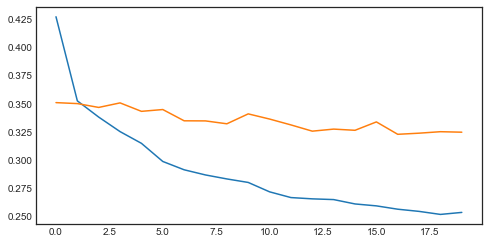

<Figure size 432x288 with 0 Axes>

In [20]:
gc.collect()
clip = 20.

for f in range(nfold):
    
    if f != fold: continue
    
    print('')
    print('*'*50)
    print(mname + ' fold ' + str(fold))
    print('*'*50)
    bname = mname+'/'+'best_'+str(fold)+'.pth'
    
    # Network definition
    net = Resnet(num_classes=28)
    
    print("Number of parameters:","{:,}".format(count_parameters(net)))
    # print(p.status())

    # classification loss
    # criterion = utils.cross_entropy2d
    # criterion = torch.nn.BCELoss()
    # criterion = dice_loss
    # criterion = BCELoss2d()
    # criterion = CombinedLoss(is_weight=False).cuda()
    # criterion = L.lovasz_hinge
    # criterion = L.lovasz2_bce1
    # criterion = L.lovasz_hinge
    # criterion = nn.BCEWithLogitsLoss()
    # criterion = FocalLoss()
    # criterion = ThreeWayLoss()

    # this gets overridden in loop below
    pw = torch.tensor([10.]).float().to(device)
    criterion = nn.BCEWithLogitsLoss(pos_weight=pw)
#     criterion = Smooth_L1_LossW(pos_weight=pw)
    # criterion = F.smooth_l1_loss
    
    # starting values for inverse positive weights
    ipw = np.array([0.3305, 0.043,  0.1031, 0.0472, 0.0525,
                       0.0852, 0.0579, 0.0508, 0.0413, 0.0569,
                       0.0406, 0.0439, 0.0432, 0.0405, 0.0549,
                       0.0424, 0.0749, 0.0428, 0.0517, 0.0512,
                       0.04,   0.0812, 0.0437, 0.0678, 0.0414,
                       0.181,  0.0422, 0.0427])

    if resume_epoch == 0:
        if len(mname0):
            bname0 = mname0+'/'+'best_'+str(fold)+'.pth'
            print(f'Initializing weights from {bname0}')
            # load best model
            best = torch.load(bname0, map_location='cpu')
            # print(best.keys())
            net.load_state_dict(best, strict=False)
    else:
        print(f'Initializing weights from {bname}')
        # load best model
        best = torch.load(bname, map_location='cpu')
        # print(best.keys())
        net.load_state_dict(best, strict=False)

    if gpu_id >= 0:
        print('Using GPU: {} '.format(gpu_id))
        torch.cuda.set_device(device=gpu_id)
        # net.cuda()
        net.train()
        net.to(device)
        
    gc.collect()
    
    # Logging into Tensorboard
    # log_dir = os.path.join(save_dir, 'models', datetime.now().strftime('%b%d_%H-%M-%S') + '_' + socket.gethostname())
    log_dir = os.path.join('tensorboard', mname + '_' + str(fold))
    writer = SummaryWriter(log_dir=log_dir)

    # Use the following optimizer
    optimizer = torch.optim.Adam(net.parameters(), lr=p['lr'])
#     optimizer = optim.SGD(net.parameters(), lr=p['lr'], momentum=p['momentum'],
#                           weight_decay=p['wd'])
#     optimizer = torch.optim.Adadelta(net.parameters(), lr=1.0, rho=0.9, eps=1e-06,
#                                      weight_decay=1e-6)
    p['optimizer'] = str(optimizer)

#     scheduler = LambdaLR(optimizer, lr_lambda=cyclic_lr)
#     scheduler.base_lrs = list(map(lambda group: 1.0, optimizer.param_groups))  
#     scheduler = ReduceLROnPlateau(optimizer, factor=0.2, patience=5, verbose=True, 
#                                   threshold=0.0, threshold_mode='abs')

    scheduler = StepLR(optimizer, step_size=p['step_size'], gamma=p['gamma'])

    torch.cuda.empty_cache()

    file_list_val = [f for f in file_list if folds[f]==fold]
    file_list_train = [f for f in file_list if f not in file_list_val]
    print('Training on ' + str(len(file_list_train)) + \
          ' and validating on ' + str(len(file_list_val)))
    
 
    db_train = MultiBandMultiLabelDataset(df.loc[file_list_train], 
                                          base_path=PATH_TO_TRAIN,
#                                           augmentator=train_aug,
                                          image_transform=composed_transforms_train)
    
    db_val = MultiBandMultiLabelDataset(df.loc[file_list_val], 
                                        base_path=PATH_TO_TRAIN,
#                                         augmentator=test_aug,
                                        image_transform=composed_transforms_test)

#     db_x = MultiBandMultiLabelDataset(dfx, 
#                                       base_path=PATH_TO_EXTERNAL,
# #                                       augmentator=train_aug,
#                                       image_transform=composed_transforms_train,
#                                       external=1)
    
    db_xx = MultiBandMultiLabelDataset(dfxx, 
                                      base_path=PATH_TO_EXTERNAL2,
#                                       augmentator=train_aug,
                                      image_transform=composed_transforms_train,
                                      external=2)
    
    db_test = MultiBandMultiLabelDataset(ss, train_mode=False,
                                        base_path=PATH_TO_TEST, 
#                                         augmentator=test_aug,
                                        image_transform=composed_transforms_test)

    # construct sampling weights as max of reciprocal class frequencies
    ylist = [t.split(' ') for t in db_train.images_df.Target]
    # print(ylist[:5])
    # build one-hot matrix
    y = np.zeros((db_train.images_df.shape[0],28))
    for i,l in enumerate(ylist):
        for j in range(len(l)): y[i,int(l[j])] = 1.
    # print(y[:20])
    # sampling weights 
    w = 1.0/np.mean(y,axis=0)
    # w = np.clip(w, 0., 1000.)
    np.set_printoptions(precision=4,linewidth=80,suppress=True)
    print('Sampling weights:')
    print(w)
    # replace 1s with weights in the one-hot matrix
    for i,l in enumerate(ylist):
        for j in range(len(l)): y[i,int(l[j])] = w[int(l[j])]
    # print(y[:10])
    # use maximum weight when there are multiple targets
    samples_weight = np.amax(y,axis=1)
    samples_weight = torch.from_numpy(samples_weight)
    sampler = WeightedRandomSampler(samples_weight.type('torch.DoubleTensor'),
                                    len(samples_weight))
    
#     # construct similar sampler for external data
#     # construct sampling weights as max of reciprocal class frequencies
#     ylistx = [t.split(' ') for t in db_x.images_df.Target]
#     # print(ylist[:5])
#     # build one-hot matrix
#     yx = np.zeros((db_x.images_df.shape[0],28))
#     for i,l in enumerate(ylistx):
#         for j in range(len(l)): yx[i,int(l[j])] = 1.
#     # sampling weights 
#     wx = 1.0/np.mean(yx,axis=0)
#     wx = np.clip(wx, 0., 3000.)
#     np.set_printoptions(precision=4,linewidth=80,suppress=True)
#     print('Sampling weights external:')
#     print(wx)
#     # replace 1s with weights in the one-hot matrix
#     for i,l in enumerate(ylistx):
#         for j in range(len(l)): yx[i,int(l[j])] = wx[int(l[j])]
#     # print(y[:10])
#     # use maximum weight when there are multiple targets
#     samples_weightx = np.amax(yx,axis=1)
#     samples_weightx = torch.from_numpy(samples_weightx)
#     samplerx = WeightedRandomSampler(samples_weightx.type('torch.DoubleTensor'),
#                                     len(samples_weightx))

    # construct similar sampler for external data 2
    # construct sampling weights as max of reciprocal class frequencies
    ylistxx = [t.split(' ') for t in db_xx.images_df.Target]
    # print(ylist[:5])
    # build one-hot matrix
    yxx = np.zeros((db_xx.images_df.shape[0],28))
    for i,l in enumerate(ylistxx):
        for j in range(len(l)): yxx[i,int(l[j])] = 1.
    # sampling weights 
    wxx = 1.0/np.mean(yxx,axis=0)
    wxx = np.clip(wxx, 0., 3000.)
    np.set_printoptions(precision=4,linewidth=80,suppress=True)
    print('Sampling weights external2:')
    print(wxx)
    # replace 1s with weights in the one-hot matrix
    for i,l in enumerate(ylistxx):
        for j in range(len(l)): yxx[i,int(l[j])] = wxx[int(l[j])]
    # print(y[:10])
    # use maximum weight when there are multiple targets
    samples_weightxx = np.amax(yxx,axis=1)
    samples_weightxx = torch.from_numpy(samples_weightxx)
    samplerxx = WeightedRandomSampler(samples_weightxx.type('torch.DoubleTensor'),
                                    len(samples_weightxx))

    trainloader = DataLoader(db_train, collate_fn=db_train.collate_func,
                             batch_size=p['trainBatch']//2, sampler=sampler,
                             num_workers=8)
#     xloader = DataLoader(db_x, collate_fn=db_x.collate_func,
#                              batch_size=p['trainBatch']//8, sampler=samplerx,
#                              num_workers=2)
    xxloader = DataLoader(db_xx, collate_fn=db_xx.collate_func,
                             batch_size=p['trainBatch']//2, sampler=samplerxx,
                             num_workers=8)
    valloader = DataLoader(db_val, collate_fn=db_train.collate_func,
                           batch_size=p['testBatch'], shuffle=False,
                          num_workers=16)
    testloader = DataLoader(db_test, collate_fn=db_test.collate_func,
                       batch_size=p['testBatch'], shuffle=False,
                      num_workers=16)
   
#     xloader_enum = enumerate(xloader)
    xxloader_enum = enumerate(xxloader)
    
    
#     # function to generate batches within ImageLoader with no arguments
#     def load_training_batch():
#         examples_batch = random.sample(list(db_train.images_df.Id.values), p['trainBatch'])
#         blist = [db_train[ex] for ex in examples_batch]
#         images = [b[0] for b in blist]
#         targets = [b[1] for b in blist]
#         return Batch(identifiers=None, images=images, targets=targets)

#     img_loader = ImageLoader(load_training_batch, nb_workers=6)
#     bg_augmenter = BackgroundAugmenter(seq, img_loader.queue, nb_workers=8)

    utils.generate_param_report(os.path.join(save_dir, mname + '.txt'), p)

    # number of batches
    num_img_tr = len(trainloader)
    num_img_ts = len(valloader)
    
    print('Image size:', final_size)
    print('Batch size:', p['trainBatch'])
    print('Batches per epoch:', num_img_tr)
    print('Epochs:', nEpochs)
    print('Loss:', criterion)
    # print('Learning rate: ', p['lr'])
    print('')
   
    running_loss_tr = 0.0
    running_loss_ts = 0.0
    aveGrad = 0
    bname = mname+'/'+'best_'+str(fold)+'.pth'
    # print("Training Network")
    history = {}
    history['epoch'] = []
    history['train'] = []
    history['val'] = []
    history['delta'] = []
    history['f1'] = []
    history['time'] = []
    best_val = -999
    bad_epochs = 0
    start_time = timeit.default_timer()
    total_time = 0
    prev_lr = 999

    # Main Training and Testing Loop
    for epoch in range(resume_epoch, nEpochs):

#         if (epoch > 0) and (epoch % p['epoch_size'] == 0):
#             lr_ = utils.lr_poly(p['lr'], epoch, nEpochs, 0.9)
#             print('(poly lr policy) learning rate', lr_)
#             print('')
#             optimizer = optim.SGD(net.parameters(), lr=lr_, momentum=p['momentum'],
#                                   weight_decay=p['wd'])

        scheduler.step()
        lr = optimizer.param_groups[0]['lr']
        if lr != prev_lr: 
            print('learning rate = %.6f' % lr)
            prev_lr = lr

        net.train()
        
        train_loss = []
        ns = 0
        
        # for ii in range(num_img_tr):
        for ii, sample_batched in enumerate(trainloader):
            
            inputs, gts = sample_batched[0], sample_batched[1]
            
#             # external data
#             try:
#                 _, xbatch = next(xloader_enum)
#             except:
#                 xloader_enum = enumerate(xloader)
#                 _, xbatch = next(xloader_enum)
            
#             inputsx, gtsx = xbatch[0], xbatch[1]
            
            # external data 2
            try:
                _, xxbatch = next(xxloader_enum)
            except:
                xxloader_enum = enumerate(xxloader)
                _, xxbatch = next(xxloader_enum)
            
            inputsxx, gtsxx = xxbatch[0], xxbatch[1]
            
#             inputs = torch.cat([inputs,inputsx,inputsxx],0)
#             gts = torch.cat([gts,gtsx,gtsxx],0)
            inputs = torch.cat([inputs,inputsxx],0)
            gts = torch.cat([gts,gtsxx],0)
                       
            # use green channel as ground truth mask for current classes
#             gi = inputs.numpy()[:,1].copy()
#             print('gi stats', gi.shape, gi.min(), gi.mean(), gi.max())
            bsize = inputs.shape[0]
            gmask = np.zeros((bsize, num_classes, gsize, gsize)).astype(float)
            for jj in range(bsize):
#                 print('gij before denorm', gi[jj].shape, gi[jj].min(),gi[jj].mean(), gi[jj].max())
#                 gij = gi[jj]*istd[1] + imean[1]
#                 print('gij after denorm', gij.shape, gij.min(), gij.mean(), gij.max())
#                 print('gij before filter', gij.shape, gij.min(), gij.mean(), gij.max())
#                 gij = gaussian_filter(gij,gstd)
#                 print('gij after filter', gij.shape, gij.min(), gij.mean(), gij.max())
#                 gij = (gij > gthresh).astype(float)
#                 print('gij after thresh', gij.shape, gij.min(), gij.mean(), gij.max())
                gr = 1.0
#                 gr = cv2.resize(gij, (gsize,gsize), interpolation=interp)
#                 grmin = gr.min()
#                 grmax = gr.max()
# #                 print('gr before rescale', gr.shape, grmin, gr.mean(), grmax)
#                 gr = (gr - grmin)/(grmax - grmin + 1e-6)
#                 print('gr after rescale', gr.shape, gr.min(), gr.mean(), gr.max())
#                 gr = (gr > gthresh).astype(int)
#                 print('gr after thresh', gr.shape, gr.min(), gr.mean(), gr.max())
#                 gr = binary_dilation(gr).astype(int)
#                 print('gr after dilation', gr.shape, gr.min(), gr.mean(), gr.max())
#                 gin = gi[jj]
#                 gin = (gin - gin.min())/(gin.max()-gin.min()+1e-6)
#                 grn = cv2.resize(gin, (gsize,gsize), interpolation=interp)
#                 print('grn stats', grn.shape, grn.min(), grn.mean(), grn.max())
#                 gr = (gr > gthresh).astype(bool).astype(int)
#                 print('gr mean batch', jj, np.mean(gr))
                for kk in np.nonzero(gts[jj]):
                    gmask[jj,kk] = gr
#                 print(jj, 'y', gts[jj])
#                 print(jj, 'gmask mean', np.average(gmask[jj], axis=(1,2)))
            
#             print('gmask',gmask.shape,gmask.min(),gmask.mean(),gmask.max())
            gmask = torch.from_numpy(gmask).float()
            
            # keep track of sampling proportions
            gt = gts.cpu().detach().numpy()
            gs = np.sum(gt,axis=0)
            if ii==0: gtsum = gs
            else: gtsum += gs
            ns += bsize

            inputs = inputs.type(torch.float).to(device)
            gts = gts.to(device)
            gmask = gmask.to(device)
            
#             # use inverse positive weights from previous iteration
#             pwb = np.zeros((bsize, num_classes, gsize, gsize))
#             for kk in range(num_classes):
#                 pwb[:,kk] = 1.0/(ipw[kk] + 1e-5)
#             pw = torch.tensor(pwb).float().to(device)
#             criterion = Smooth_L1_LossW(pos_weight=pw)

            # predictions are heat maps on a probability scale
            logits = net(inputs)
            logits = torch.clamp(logits, min=-clip, max=clip)
            
#             class_loss = criterion(logits, gts)
            
#             first = True
#             for kk in range(num_classes):
#                 lossk = criterion2(seg[:,kk], gmask[:,kk])
#                 # print('seg_loss batch', jj, ' class', kk, lossjk.item())
#                 if first: 
#                     seg_loss = lossk
#                     first = False
#                 else: seg_loss = seg_loss + lossk
#             seg_loss = seg_loss / num_classes

             
            # print('class_loss', class_loss.item())
            # print('seg_loss', seg_loss.item())
#             loss = class_loss + 0.5 * seg_loss

            loss = criterion(logits, gmask)
#             print(ii, loss.item())
            
            optimizer.zero_grad()
            loss.backward()
            
            # adamw
            for group in optimizer.param_groups:
                for param in group['params']:
                    param.data = param.data.add(-p['wd'] * group['lr'], param.data)

            optimizer.step()
            train_loss.append(loss.item())                        
            running_loss_tr += loss.item()
        
        print('epoch ' + str(epoch) + ' training class proportions:')
        print(gtsum/ns)
        
        # validation
        net.eval()
        
        with torch.no_grad():

            val_loss = []
            val_predictions = []
            val_targets = []
        
            for ii, sample_batched in enumerate(valloader):

                # >>> #In your test loop you can do the following:
                # >>> input, target = batch # input is a 5d tensor, target is 2d
                # >>> bs, ncrops, c, h, w = input.size()
                # >>> result = model(input.view(-1, c, h, w)) # fuse batch size and ncrops
                # >>> result_avg = result.view(bs, ncrops, -1).mean(1) # avg over crops

                # inputs, gts = sample_batched['image'], sample_batched['gt']
                inputs, gts = sample_batched[0], sample_batched[1]
        
                # fuse batch size and ncrops
                bsize, ncrops, c, h, w = inputs.size()
                # print(bsize, ncrops, c, h, w)
                inputs = inputs.view(-1, c, h, w)

                # use thresholded green channel as ground truth mask for current classes
#                 gi = inputs.numpy()[:,1].copy()
#                 bsize = inputs.shape[0]
                gmask = np.zeros((bsize, num_classes, gsize, gsize)).astype(float)
        
                for jj in range(bsize):
    #                 print('gij before denorm', gi[jj].shape, gi[jj].min(),
    #                       gi[jj].mean(), gi[jj].max())
#                     gij = gi[jj]*istd[1] + imean[1]
    #                 print('gij after denorm', gij.shape, gij.min(), gij.mean(), gij.max())
    #                 print('gij before filter', gij.shape, gij.min(), gij.mean(), gij.max())
    #                 gij = gaussian_filter(gij,gstd)
    #                 print('gij after filter', gij.shape, gij.min(), gij.mean(), gij.max())
    #                 gij = (gij > gthresh).astype(float)
    #                 print('gij after thresh', gij.shape, gij.min(), gij.mean(), gij.max())
                    gr = 1.0
#                     gr = cv2.resize(gij, (gsize,gsize), interpolation=interp)
#                     grmin = gr.min()
#                     grmax = gr.max()
#     #                 print('gr before rescale', gr.shape, grmin, gr.mean(), grmax)
#                     gr = (gr - grmin)/(grmax - grmin + 1e-6)
    #                 print('gr after rescale', gr.shape, gr.min(), gr.mean(), gr.max())
    #                 gr = (gr > gthresh).astype(int)
    #                 print('gr after thresh', gr.shape, gr.min(), gr.mean(), gr.max())
    #                 gr = binary_dilation(gr).astype(int)
    #                 print('gr after dilation', gr.shape, gr.min(), gr.mean(), gr.max())
    #                 gin = gi[jj]
    #                 gin = (gin - gin.min())/(gin.max()-gin.min()+1e-6)
    #                 grn = cv2.resize(gin, (gsize,gsize), interpolation=interp)
    #                 print('grn stats', grn.shape, grn.min(), grn.mean(), grn.max())
    #                 gr = (gr > gthresh).astype(bool).astype(int)
    #                 print('gr mean batch', jj, np.mean(gr))
                    for kk in np.nonzero(gts[jj]):
                        gmask[jj,kk] = gr
    #                 print(jj, 'y', gts[jj])
    #                 print(jj, 'gmask mean', np.average(gmask[jj], axis=(1,2)))

                gmask = torch.from_numpy(gmask).float()
                
                # tta horizontal flip
                inputs2 = inputs.numpy()[:,:,:,::-1].copy()
                inputs2 = torch.from_numpy(inputs2)

                inputs = inputs.type(torch.float).to(device)
                inputs2 = inputs2.type(torch.float).to(device)

                # predictions are on a logit scale
                logits = net(inputs)
                # average over crops
                logits = logits.view(bsize, ncrops, num_classes, gsize, gsize).mean(1)
                logits2 = net(inputs2)
                # average over crops
                logits2 = logits2.view(bsize, ncrops, num_classes, gsize, gsize).mean(1)
                logits2 = logits2.cpu().detach().numpy()[:,:,:,::-1].copy()
                logits2 = torch.from_numpy(logits2).to(device)
                logits = (logits + logits2)/2.0
                
                logits = torch.clamp(logits, min=-clip, max=clip)
                
#                 # use inverse positive weights from this iteration
#                 pwb = np.zeros((bsize, num_classes, gsize, gsize))
#                 for kk in range(num_classes):
#                     pwb[:,kk] = 1.0/(ipw[kk] + 1e-5)
#                 pw = torch.tensor(pwb).float().to(device)
#                 criterion = Smooth_L1_LossW(pos_weight=pw)
                
                loss = criterion(logits, gmask.to(device))

                running_loss_ts += loss.item()
                val_loss.append(loss.item())

                # save results to compute F1 on validation set
                preds = logits.cpu().detach().numpy()
                gt = gts.cpu().detach().numpy()

                val_predictions.append(preds)
                val_targets.append(gt)

            vps = np.vstack(val_predictions)
            vts = np.vstack(val_targets)
            
            # competition metric
            # use percentile to as single prediction for f1
            vpsp = np.percentile(vps, gpct, axis=(2,3))
            thresholds = np.linspace(-5, 5, 101)
            scores = np.array([f1_score(vts, np.int32(vpsp > t),
                                    average='macro') for t in thresholds])
            threshold_best_index = np.argmax(scores)
            vf1 = scores[threshold_best_index]
            tbest = thresholds[threshold_best_index]
            # vf1 = f1_score(vts,(vps > 0).astype(int), average='macro')

            if vf1 > best_val:
                star = '*'
                best_val = vf1
                torch.save(net.state_dict(), bname)
                bad_epochs = 0
            else:
                star = ' '
                bad_epochs += 1
                
            # print progress
            # running_loss_ts = running_loss_ts / num_img_ts

            tl = np.mean(train_loss)
            vl = np.mean(val_loss)

            stop_time = timeit.default_timer()
            diff_time = (stop_time - start_time)/60.
            total_time += diff_time
            start_time = timeit.default_timer()

            print('epoch %d  train %6.4f  val %6.4f  delta %6.4f  f1 %6.4f%s  thresh %3.1f  time %4.1f%s\n' % \
                  (epoch, tl, vl, vl-tl, vf1, star, tbest, diff_time, 'm'))
            writer.add_scalar('loss', tl, epoch)
            writer.add_scalar('val_loss', vl, epoch)
            writer.add_scalar('delta', vl-tl, epoch)
            writer.add_scalar('val_f1', vf1, epoch)
            writer.add_scalar('thresh', tbest, epoch)
            writer.add_scalar('time', diff_time, epoch)
            # print('Running Loss: %f\n' % running_loss_ts)
            # print('Mean Loss: %f\n' % np.mean(val_loss))
            running_loss_tr = 0
            running_loss_ts = 0

            history['epoch'].append(epoch)
            history['train'].append(tl)
            history['val'].append(vl)
            history['f1'].append(vf1)
            history['time'].append(diff_time)

            if bad_epochs > p['patience']:
                print('early stopping, best validation loss %6.4f, total time %4.1f minutes \n' % \
                      (best_val, total_time))
                break
            
    writer.close()

    # plot history
    fig, (ax_loss) = plt.subplots(1, 1, figsize=(8,4))
    ax_loss.plot(history['epoch'], history['train'], label="Train loss")
    ax_loss.plot(history['epoch'], history['val'], label="Validation loss")
    plt.show()
    plt.gcf().clear()

In [21]:
# load best model
best = torch.load(bname, map_location='cpu')
# print(best.keys())
net.load_state_dict(best)
net = net.eval()

In [22]:
with torch.no_grad():
    # predict validation set
    val_logits = []
    val_y = []
    # for image, mask in tqdm.tqdm(data.DataLoader(dataset_val, batch_size = 30)):
    batch = 0
    for image, y in valloader:
        
        # fuse batch size and ncrops
        bsize, ncrops, c, h, w = image.size()
        image = image.view(-1, c, h, w)
        
        # test-time augmentation with horizontal flipping
        image2 = image.numpy()[:,:,:,::-1].copy()
        image2 = torch.from_numpy(image2)
        image = image.type(torch.float).to(device)
        image2 = image2.type(torch.float).to(device)
        logits = net(image)
        # average over crops
        logits = logits.view(bsize, ncrops, num_classes, gsize, gsize).mean(1)
        logits = logits.cpu().detach().numpy()
        logits2 = net(image2)
        # average over crops
        logits2 = logits2.view(bsize, ncrops, num_classes, gsize, gsize).mean(1)
        logits2 = logits2.cpu().detach().numpy()
        logits2 = logits2[:,:,:,::-1]
        logits = (logits + logits2)/2.0
             
        val_logits.append(logits)

        y = y.cpu().detach().numpy()
        val_y.append(y)

        batch += 1

    vls = np.vstack(val_logits)
    vys = np.vstack(val_y)

    print(vls.shape, vys.shape)

(4867, 28, 1, 1) (4867, 28)


In [23]:
print(logits.shape,logits.min(),logits.mean(),logits.max())
print(logits2.shape,logits2.min(),logits2.mean(),logits2.max())

(3, 28, 1, 1) -11.291902 -3.9501576 4.3789625
(3, 28, 1, 1) -11.301024 -4.001251 4.410045


In [24]:
clip = 15
vpc = np.array([np.clip(logits.flatten(),0.,clip), np.clip(logits2.flatten(),0.,clip)])

# tpsf = np.hstack([c.reshape((-1,1)) for c in tps])
print(vpc.shape)

(2, 84)


In [25]:
np.corrcoef(vpc)

array([[1.    , 0.9996],
       [0.9996, 1.    ]])

In [26]:
# save out-of-fold predictions
oof_ids = file_list_val
poof = vls.copy()
yoof = vys.copy()

oof = [oof_ids, poof, yoof]
fname = 'oof/'+mname+'_'+str(fold)+'.pkl'
pickle.dump(oof,open(fname,'wb'))
print(fname)

oof/preresnet_x67_0.pkl



f1_best 0.6106220212046285
threshold_best 1.5



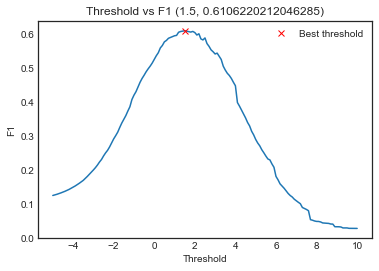

<Figure size 432x288 with 0 Axes>

In [27]:
# grid search for best threshold
# note predictions and thresholds are on logit scale
vlsp = np.percentile(vls, gpct, axis=(2,3))
# vlsp = np.average(vls, axis=(2,3))

thresholds = np.linspace(-5, 10, 151)
scores = np.array([f1_score(vys, (vlsp > t).astype(int), average='macro') \
                 for t in thresholds])

threshold_best_index = np.argmax(scores)
score_best = scores[threshold_best_index]
threshold_best = thresholds[threshold_best_index]
print('')
print('f1_best',score_best)
print('threshold_best',threshold_best)
print('')

plt.plot(thresholds, scores)
plt.plot(threshold_best, score_best, "xr", label="Best threshold")
plt.xlabel("Threshold")
plt.ylabel("F1")
plt.title("Threshold vs F1 ({}, {})".format(threshold_best, score_best))
plt.legend()
plt.show()
plt.gcf().clear()

-19.278430938720703 -4.05808748595001 15.991775512695312 (136276,)


/home/sasrdw/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


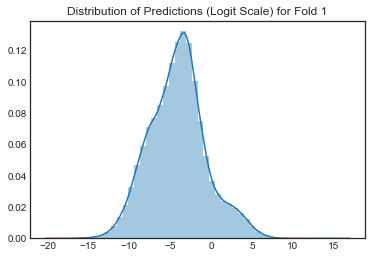

<Figure size 432x288 with 0 Axes>

In [28]:
vf = vlsp.flatten()
print(vf.min(),vf.mean(),vf.max(),vf.shape)
sns.distplot(vf)
plt.title("Distribution of Predictions (Logit Scale) for Fold " + str(fold+1))
plt.show()
plt.gcf().clear()

In [29]:
np.mean(vys,axis=0)

array([0.4109, 0.0312, 0.0748, 0.0358, 0.0279, 0.0707, 0.0466, 0.0614, 0.0008,
       0.0006, 0.    , 0.0212, 0.0325, 0.022 , 0.0618, 0.0002, 0.0212, 0.0049,
       0.0351, 0.0534, 0.0023, 0.2404, 0.0483, 0.0688, 0.0111, 0.4572, 0.0064,
       0.0004], dtype=float32)

In [30]:
# error analysis
from sklearn.metrics import confusion_matrix

cm = [confusion_matrix(vys[:,i], (vlsp[:,i] > threshold_best).astype(int)) \
       for i in range(vys.shape[1])]
fm = [f1_score(vys[:,i], (vlsp[:,i] > threshold_best).astype(int)) \
       for i in range(vys.shape[1])]
for i in range(vys.shape[1]):
    print(LABEL_MAP[i])
    print(cm[i], '%4.2f' % fm[i])
    print('')

Nucleoplasm
[[2328  539]
 [ 253 1747]] 0.82

Nuclear membrane
[[4660   55]
 [  25  127]] 0.76

Nucleoli
[[4433   70]
 [ 113  251]] 0.73

Nucleoli fibrillar center
[[4669   24]
 [  49  125]] 0.77

Nuclear speckles
[[4697   34]
 [  50   86]] 0.67

Nuclear bodies
[[4477   46]
 [ 149  195]] 0.67

Endoplasmic reticulum
[[4521  119]
 [  96  131]] 0.55

Golgi apparatus
[[4538   30]
 [ 123  176]] 0.70

Peroxisomes
[[4863    0]
 [   2    2]] 0.67

Endosomes
[[4864    0]
 [   0    3]] 1.00

Lysosomes
[[4867]] 0.00

Intermediate filaments
[[4748   16]
 [  48   55]] 0.63

Actin filaments
[[4656   53]
 [  34  124]] 0.74

Focal adhesion sites
[[4723   37]
 [  25   82]] 0.73

Microtubules
[[4482   84]
 [  10  291]] 0.86

Microtubule ends
[[4861    5]
 [   0    1]] 0.29

Cytokinetic bridge
[[4617  147]
 [  64   39]] 0.27

Mitotic spindle
[[4809   34]
 [  20    4]] 0.13

Microtubule organizing center
[[4668   28]
 [  92   79]] 0.57

Centrosome
[[4567   40]
 [ 137  123]] 0.58

Lipid droplets
[[4850    6

In [31]:
np.mean(fm)

0.6106220212046285

In [32]:
# fm1 = [f for f in fm if f > 0]
# print(len(fm1))
# print(np.mean(fm1))

0.0 0.7057853180310546 1.0


/home/sasrdw/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


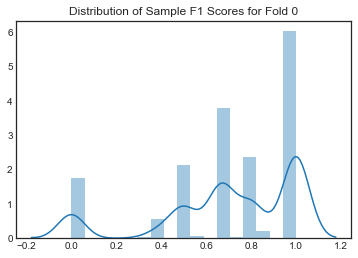

<Figure size 432x288 with 0 Axes>

In [33]:
f1b = np.array([f1_score(y, (l > threshold_best).astype(int)) \
                 for y,l in zip(vys,vlsp)])
print(f1b.min(),f1b.mean(),f1b.max())
sns.distplot(f1b)
plt.title("Distribution of Sample F1 Scores for Fold " + str(fold))
plt.show()
plt.gcf().clear()

In [34]:
len(f1b)

4867

TypeError: Invalid dimensions for image data

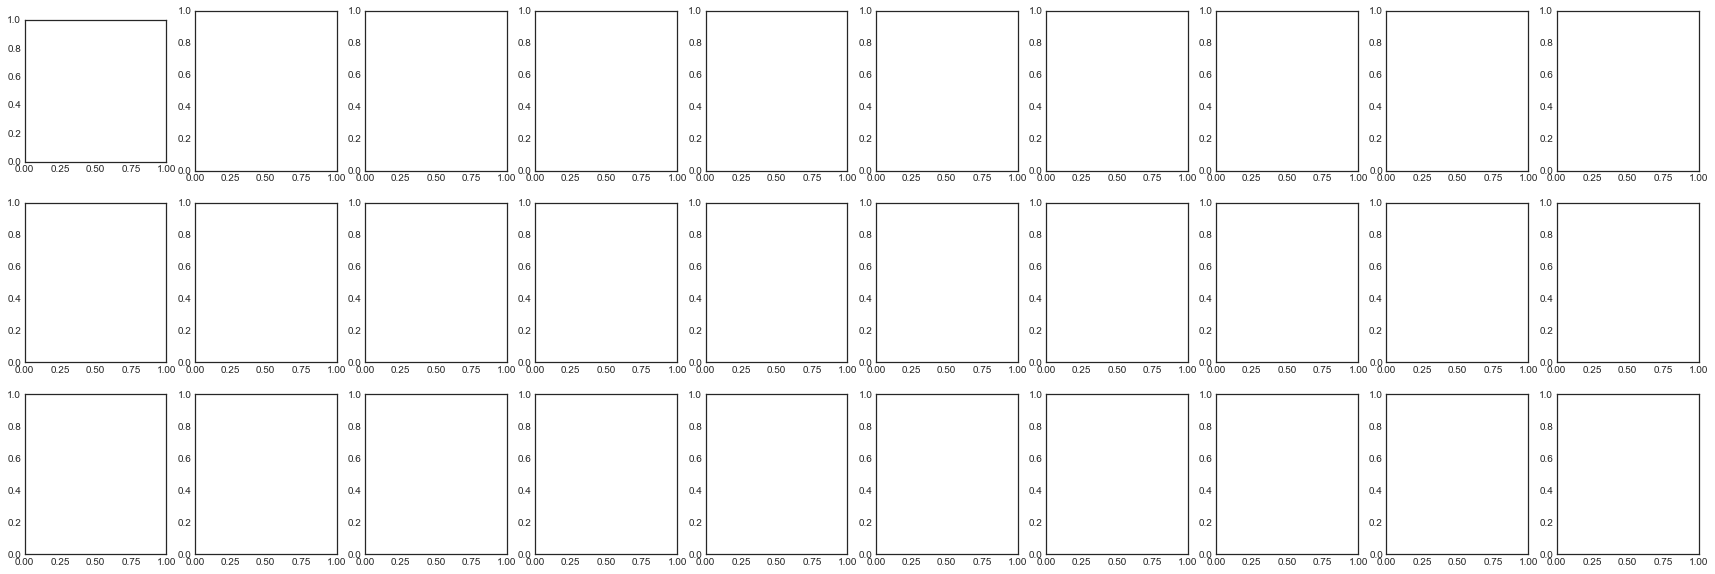

In [35]:
# plot validation images with scores
# sort from worst to best
order = f1b.argsort()
max_images = 90
# max_images = len(file_list_val)
start = 0
# start = 200
grid_width = 10
grid_height = int(max_images / grid_width)
# print(max_images,grid_height,grid_width)

file_list_val_reordered = [file_list_val[order[i]] for i,f in enumerate(file_list_val)]

for i, idx in enumerate([file_list_val_reordered[i] for i in range(start,(start+max_images))]):
    imod = i % 30
    if imod == 0:
        fig, axs = plt.subplots(3, 10, figsize=(30, 10))
    img, y = db_val[order[i]]

    img = img[0].data.numpy()[1]
    img = img[y_min_pad:(image_size - y_max_pad), x_min_pad:(image_size - x_max_pad)]

    true = np.nonzero(vys[order][start+i])
    true_str = ' '.join(map(str, true))
    pred = np.nonzero((vlsp[order][start+i] > threshold_best).astype(int))
    pred_str = ' '.join(map(str, pred))
    ax = axs[int(imod / grid_width), imod % grid_width]
    ax.imshow(img, cmap='Greens')
    ax.set_title(str(i) + '   ' + idx[:13] + '\n' + true_str + '  ' + pred_str)
    # ax.set_xlabel(str(round(ioub[i], 3)))
    ax.set_xlabel('%4.2f' % (f1b[order][start+i]))
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    if imod == 29:
        # plt.suptitle("Green: salt, Red: prediction. Top-left: coverage class, Top-right: salt coverage, Bottom-left: depth, Bottom-right: IOU")
        plt.show()
        plt.gcf().clear()
        gc.collect()    

In [36]:
print(ss.head())
print(ss.shape)

                                      Predicted
Id                                             
00008af0-bad0-11e8-b2b8-ac1f6b6435d0          0
0000a892-bacf-11e8-b2b8-ac1f6b6435d0          0
0006faa6-bac7-11e8-b2b7-ac1f6b6435d0          0
0008baca-bad7-11e8-b2b9-ac1f6b6435d0          0
000cce7e-bad4-11e8-b2b8-ac1f6b6435d0          0
(11702, 1)


In [38]:
clip = 20
with torch.no_grad():
    print('predicting test set for bagging')
    tp = {}
    for i in range(8): tp[i] = []
    
    # 8-way TTA
    # for image in tqdm.tqdm(data.DataLoader(test_dataset, batch_size = 30)):
    for image in testloader:
        
        # fuse batch size and ncrops
        bsize, ncrops, c, h, w = image[0].size()
        image = image[0].view(-1, c, h, w)
        
        i = 0
        image1 = image.numpy().copy()
        # move channels last for augmentation
        image1 = np.transpose(image1, (0, 2, 3, 1))
       
        image = image.type(torch.float).to(device)
        logits = net(image)
        # average over crops
        logits = logits.view(bsize, ncrops, num_classes, gsize, gsize).mean(1)
        logits = logits.cpu().detach().numpy()
        logits = np.clip(logits,-clip,clip)
        tp[i].append(logits)
        i += 1
       
        for degrees in [90, 180, 270]:
            IAA = iaa.Affine(rotate=degrees)
            image2 = np.array([IAA.augment_image(imi) for imi in image1])
            # move channels first for pytorch
            image2 = np.transpose(image2, (0, 3, 1, 2))
            image2 = torch.from_numpy(image2)
            image2 = image2.type(torch.float).to(device)
            logits2 = net(image2)
            # average over crops
            logits2 = logits2.view(bsize, ncrops, num_classes, gsize, gsize).mean(1)
            logits2 = logits2.cpu().detach().numpy()
            logits2 = np.clip(logits2,-clip,clip)
            IAA = iaa.Affine(rotate=-degrees)
            logits2 = np.transpose(logits2, (0, 2, 3, 1))
            logits2 = np.array([IAA.augment_image(imi) for imi in logits2])
            logits2 = np.transpose(logits2, (0, 3, 1, 2))
            tp[i].append(logits2)
            i += 1
        
        # horizontally flip image1
        IAA = iaa.Fliplr(1.0)
        image1 = np.array([IAA.augment_image(imi) for imi in image1])
        image2 = np.transpose(image1, (0, 3, 1, 2))
        image2 = torch.from_numpy(image2)
        image2 = image2.type(torch.float).to(device)
        logits2 = net(image2)
        # average over crops
        logits2 = logits2.view(bsize, ncrops, num_classes, gsize, gsize).mean(1)
        logits2 = logits2.cpu().detach().numpy()
        logits2 = np.clip(logits2,-clip,clip)
        logits2 = np.transpose(logits2, (0, 2, 3, 1))
        logits2 = np.array([IAA.augment_image(imi) for imi in logits2])
        logits2 = np.transpose(logits2, (0, 3, 1, 2))
        tp[i].append(logits2)
        i += 1
        
        # rotations again on flipped image
        for degrees in [90, 180, 270]:
            IAA = iaa.Affine(rotate=degrees)
            image2 = np.array([IAA.augment_image(imi) for imi in image1])
            image2 = np.transpose(image2, (0, 3, 1, 2))
            image2 = torch.from_numpy(image2)
            image2 = image2.type(torch.float).to(device)
            logits2 = net(image2)
            # average over crops
            logits2 = logits2.view(bsize, ncrops, num_classes, gsize, gsize).mean(1)
            logits2 = logits2.cpu().detach().numpy()
            logits2 = np.clip(logits2,-clip,clip)
            IAA = iaa.Affine(rotate=-degrees)
            logits2 = np.transpose(logits2, (0, 2, 3, 1))
            logits2 = np.array([IAA.augment_image(imi) for imi in logits2])
            IAA = iaa.Fliplr(1.0)
            logits2 = np.array([IAA.augment_image(imi) for imi in logits2])
            logits2 = np.transpose(logits2, (0, 3, 1, 2))
            tp[i].append(logits2)
            i += 1
         
    tps = np.array([np.vstack(tp[i]) for i in range(8)])
    print(tps.shape)

tpsf = np.hstack([c.reshape((-1,1)) for c in tps])
print(tpsf.shape)

np.set_printoptions(precision=3,linewidth=100)
print(np.corrcoef(tpsf, rowvar=False))

ptest = np.median(tps,axis=0)
ptesta = np.amax(tps,axis=0)
print(ptest.shape)

predicting test set for bagging
(8, 11702, 28, 1, 1)
(327656, 8)
[[1.    0.99  0.993 0.99  0.995 0.99  0.994 0.992]
 [0.99  1.    0.99  0.993 0.99  0.994 0.992 0.995]
 [0.993 0.99  1.    0.99  0.994 0.992 0.995 0.99 ]
 [0.99  0.993 0.99  1.    0.992 0.995 0.99  0.994]
 [0.995 0.99  0.994 0.992 1.    0.99  0.993 0.99 ]
 [0.99  0.994 0.992 0.995 0.99  1.    0.99  0.993]
 [0.994 0.992 0.995 0.99  0.993 0.99  1.    0.99 ]
 [0.992 0.995 0.99  0.994 0.99  0.993 0.99  1.   ]]
(11702, 28, 1, 1)


TypeError: Invalid dimensions for image data

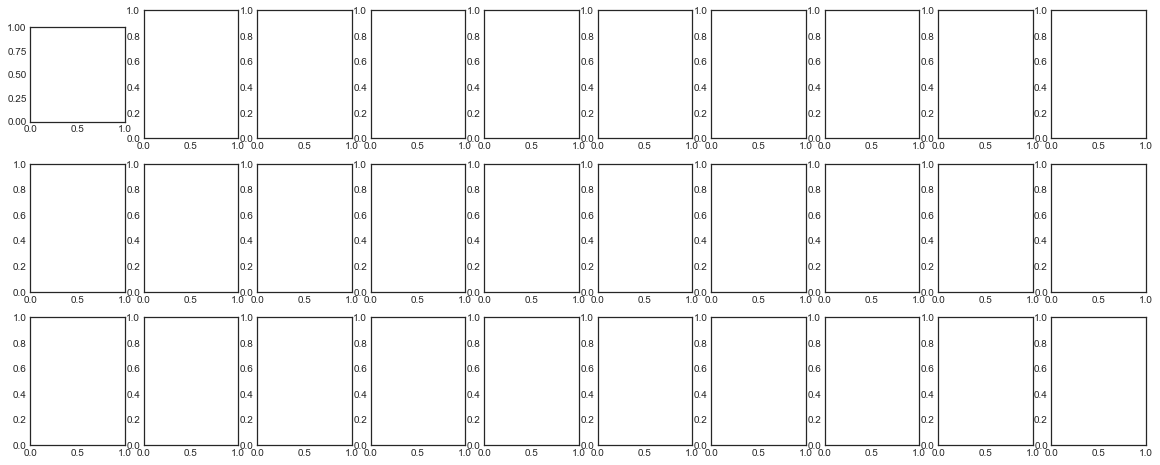

In [39]:
# show some test images
nshow = 50
start = np.random.randint(len(test_file_list)-nshow)
stop = start + nshow
grid_width = 10
grid_height = int(max_images / grid_width)
# print(max_images,grid_height,grid_width)
ni = 10
for j in range(int(start/10),int(stop/10)):
    jj = j*10
    fig, axs = plt.subplots(3, ni, figsize=(20,8))
    for i in range(ni):
        img = db_test[jj+i][0]
        img = img[0].data.numpy()
        img = img[:,y_min_pad:(image_size - y_max_pad),
                    x_min_pad:(image_size - x_max_pad)]
        # img = cv2.resize(img,(ori_size,ori_size),interpolation=interp)
        pred = np.nonzero((ptest[jj+i] > threshold_best).astype(int))
        # pred_str = list(pred)
        # pred_str = np.char.mod('%d', pred)
        # pred_str = " ".join(pred_str)
        pred_str = ' '.join(map(str, pred))
        axs[0][i].imshow(img[0], cmap="Reds")
        axs[1][i].imshow(img[1], cmap="Greens")
        axs[2][i].imshow(img[2], cmap="Blues")
#         axs[3][i].imshow(img[3], cmap="Oranges")
#         axs[0][i].set_title(pred_str)
    # fig.suptitle("Top row: original, bottom row: green channel")
    plt.show()
    plt.gcf().clear()

#     # clean up to save on memory accumulation across folds
#     del net
#     del inputs, gts
#     del image, image2
#     del writer, scheduler, optimizer
#     del y_pred, y_pred2
#     torch.cuda.empty_cache()
#     gc.collect()

In [40]:
sub = [test_file_list, ptest, ptesta]
fname = 'sub/'+mname+'_'+str(fold)+'_mm.pkl'
pickle.dump(sub,open(fname,'wb'))
print(fname)

sub/preresnet_x67_0_mm.pkl
